In [1]:
##Importing packages we need##

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from matplotlib.cm import get_cmap
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import metpy.calc as mpcalc
from metpy.units import units
from numpy import *
import xarray as xr
from netCDF4 import Dataset, num2date
import math
import pygrib
import cdsapi
import imageio
import os
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import metpy as mp
import warnings
import glob
import dask
warnings.filterwarnings("ignore")

print("Done importing modules")

Done importing modules


In [2]:
# ##Declare time, level, lat/lon boundaries and loop through a 2-day period for Frontal Analysis##

#Area and Time#
colorado_area = [44, -112, 34, -99]  #some buffer on all sides
latN = 44
latS = 34
lonW = -112    #Must be in degrees E (The western hemisphere is captured between 180 and 360 degrees east)
lonE = -99
level = 850    #What level do we want to look at FLF on

In [3]:
##Get all the ERA5 files##

path_pattern = 'CF_DATA/ERA5*.nc'
#path_pattern = 'Data_Remake/*.nc'

files = glob.glob(path_pattern, recursive=True)

files_sorted = sorted(files)
files_sorted[710]

'CF_DATA/ERA5_12_23_2022.nc'

In [4]:
##Import the Test Case##

#ds = xr.open_dataset(files_sorted[8]).metpy.parse_cf()
ds = xr.open_dataset(files_sorted[710]).metpy.parse_cf()
#ds_sfc = ds.isel(time=slice(24, 96))  #only for edge cases
ds_sfc = ds.copy()
ds_sfc

#ds["time"].values[96:168]   #edge years day 1:   ds_sfcs ds.isel(time=slice(96, 168))
#ds["time"].values[120:192]  #edge years day 2:   ds.isel(time=slice(120, 192))
#ds["time"].values[24:96]    #edge months day 1:  ds.isel(time=slice(24, 96))
#ds["time"].values[48:120]   #edge months day 2:  ds.isel(time=slice(48, 120))

<xarray.Dataset>
Dimensions:    (longitude: 53, latitude: 41, time: 72)
Coordinates:
  * longitude  (longitude) float32 -112.0 -111.8 -111.5 ... -99.5 -99.25 -99.0
  * latitude   (latitude) float32 44.0 43.75 43.5 43.25 ... 34.5 34.25 34.0
  * time       (time) datetime64[ns] 2022-12-21 ... 2022-12-23T23:00:00
    metpy_crs  object Projection: latitude_longitude
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-22 05:41:00 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [5]:
##Load in the datasets and read in variables and cords##

#This is for the surface level#
dew_2m = ds_sfc.d2m.metpy.sel(latitude=slice(latN,latS),longitude=slice(lonW,lonE))
uwnd_10m = ds_sfc.u10.metpy.sel(latitude=slice(latN,latS),longitude=slice(lonW,lonE))
vwnd_10m = ds_sfc.v10.metpy.sel(latitude=slice(latN,latS),longitude=slice(lonW,lonE))
tmpk_2m = ds_sfc.t2m.metpy.sel(latitude=slice(latN,latS),longitude=slice(lonW,lonE))
mslp = ds_sfc.msl.metpy.sel(latitude=slice(latN,latS),longitude=slice(lonW,lonE))
sfc_p = ds_sfc.sp.metpy.sel(latitude=slice(latN,latS),longitude=slice(lonW,lonE))

#Extract Coordinates#
lats = ds_sfc.latitude.metpy.sel(latitude=slice(latN,latS))
lons = ds_sfc.longitude.metpy.sel(longitude=slice(lonW,lonE))
lons_2D, lats_2D = meshgrid(lons,lats)
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

tmpk_2m

<xarray.DataArray 't2m' (time: 72, latitude: 41, longitude: 53)>
[156456 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -112.0 -111.8 -111.5 ... -99.5 -99.25 -99.0
  * latitude   (latitude) float32 44.0 43.75 43.5 43.25 ... 34.5 34.25 34.0
  * time       (time) datetime64[ns] 2022-12-21 ... 2022-12-23T23:00:00
    metpy_crs  object Projection: latitude_longitude
Attributes:
    units:      K
    long_name:  2 metre temperature

In [6]:
##Apply a spatial smoother to the variables so that synoptic-scale signals can be more readily observed (25)##

smoothing_var = 15

#Surface variables#
dew_2m = mpcalc.smooth_gaussian(dew_2m, smoothing_var)
uwnd_10m = mpcalc.smooth_gaussian(uwnd_10m, smoothing_var)
vwnd_10m = mpcalc.smooth_gaussian(vwnd_10m, smoothing_var)
tmpk_2m = mpcalc.smooth_gaussian(tmpk_2m, smoothing_var)
mslp = mpcalc.smooth_gaussian(mslp, smoothing_var)
sfc_p = mpcalc.smooth_gaussian(sfc_p, smoothing_var)


In [7]:
##Calculate additional variables to plot##

#Surface level variables#
thetaE = mpcalc.equivalent_potential_temperature(sfc_p, tmpk_2m, dew_2m) 
thetaE_adv = mpcalc.advection(thetaE, uwnd_10m, vwnd_10m)

#Scale by a factor#
thetaE_adv_s = thetaE_adv * 1e4

#Select only CAA and WAA#
thetaE_adv_s_CAA = thetaE_adv_s.where(thetaE_adv_s < 0, other=np.nan)
thetaE_adv_s_WAA = thetaE_adv_s.where(thetaE_adv_s > 0, other=np.nan)

thetaE_adv_s


<xarray.DataArray (time: 72, latitude: 41, longitude: 53)>
<Quantity([[[ 2.25555013e-02 -1.96887560e-01 -4.07720932e-01 ...  6.75916473e-02
    6.41315488e-02  3.66882242e-02]
  [ 2.28091551e-01  2.08288933e-02 -1.94941330e-01 ...  5.47404255e-02
    4.82845368e-02  2.05785795e-02]
  [ 3.89578325e-01  2.05622921e-01 -2.82104348e-03 ...  2.78171051e-02
    1.67451830e-02 -1.00332618e-02]
  ...
  [ 2.86672275e-02  9.05685987e-03 -1.09627585e-02 ... -3.91253539e-01
   -3.73697899e-01 -3.41147781e-01]
  [ 1.31067108e-02 -6.65005669e-03 -2.70163105e-02 ... -3.17152656e-01
   -2.94879102e-01 -2.69282204e-01]
  [-2.58370131e-05 -2.08143103e-02 -4.60172364e-02 ... -2.20824756e-01
   -1.70069932e-01 -1.31519426e-01]]

 [[ 5.12937651e-02 -1.93446464e-01 -4.43636894e-01 ...  4.62248977e-03
    7.55772646e-03  5.33586633e-03]
  [ 2.50739304e-01  1.17541487e-02 -2.48891118e-01 ...  8.62918338e-03
    9.69510357e-03  7.35640595e-03]
  [ 3.68036692e-01  1.55214367e-01 -8.89673280e-02 ...  2.03717357e-02
    1.74615677e-02  1.40896593e-02]
...
  [-9.82362133e-03 -1.35709566e-04 -1.27077749e-03 ...  1.94736072e-01
    1.66153329e-01  1.20458912e-01]
  [-3.50311297e-02 -4.61025266e-02 -4.38761968e-02 ...  1.72754799e-01
    1.45732317e-01  1.02435209e-01]
  [-5.37772254e-02 -8.35748341e-02 -8.84014241e-02 ...  1.39037733e-01
    1.11625957e-01  6.88889895e-02]]

 [[ 7.86710471e-02  1.66660733e-01  2.81051739e-01 ... -2.69851518e-02
   -9.45751031e-02 -1.54778039e-01]
  [ 1.79921449e-01  2.73750033e-01  3.86094604e-01 ... -3.51788528e-01
   -4.15597925e-01 -4.82428130e-01]
  [ 3.67951457e-01  4.46333147e-01  5.22472538e-01 ... -6.15474636e-01
   -6.90658473e-01 -7.79729871e-01]
  ...
  [-9.15415179e-03 -3.76986417e-04 -9.85705207e-03 ...  1.48852693e-01
    1.18563654e-01  7.25886675e-02]
  [-3.45460445e-02 -3.94423909e-02 -3.45088607e-02 ...  1.36588871e-01
    1.07934105e-01  6.45361841e-02]
  [-5.55197499e-02 -7.80567762e-02 -7.46008535e-02 ...  1.20730242e-01
    9.17328651e-02  4.88685747e-02]]], 'kelvin / second')>
Coordinates:
  * longitude  (longitude) float32 -112.0 -111.8 -111.5 ... -99.5 -99.25 -99.0
  * latitude   (latitude) float32 44.0 43.75 43.5 43.25 ... 34.5 34.25 34.0
  * time       (time) datetime64[ns] 2022-12-21 ... 2022-12-23T23:00:00
    metpy_crs  object Projection: latitude_longitude

In [8]:
##Calculate Front Locator Function (FLF) using ThetaE##

def calculate_flf(thetaE, dx, dy):
    '''Make an FLF function to calculate it for all gridpoints at each timestep.'''
    
    #Step 1: Calculate the gradient of thetaE#
    d0_dy, d0_dx = mpcalc.gradient(thetaE, deltas=(dy, dx)) 
    
    #Step 2: Calculate the magnitude of the gradient#
    mag_grad_thetaE = np.sqrt((d0_dx**2) + (d0_dy**2))  # |grad(thetaE)|
    
    #Step 3a: Calculate the gradient of the magnitude#
    grad_step2_y, grad_step2_x = mpcalc.gradient(mag_grad_thetaE, deltas=(dy, dx))
    
    #Step 3b: Redo but for Qn component only#
    qx = grad_step2_x.copy()
    qy = grad_step2_y.copy()
    denominator = ((d0_dx) * (d0_dx)) + ((d0_dy) * (d0_dy))

    Qn_x = (((qx) * (d0_dx) * (d0_dx)) + ((qy) * (d0_dy) * (d0_dx))) / (denominator)  #i component
    Qn_y = (((qx) * (d0_dx) * (d0_dy)) + ((qy) * (d0_dy) * (d0_dy))) / (denominator)  #j component
    #Qn_low = Qn_x + Qn_y
    #Qn = Qn_low * 1e10
    
    #Step 4: Calculate the divergence of the gradient of the magnitude with Qn component#
    div_step4_Qn = mpcalc.divergence(Qn_x, Qn_y, dx=dx, dy=dy)
    div_step4_Qn_convert = div_step4_Qn * 1e14  #What we need
    
    return div_step4_Qn_convert

#Apply the function across all timesteps now#
FLF_data = xr.apply_ufunc(
    calculate_flf, 
    thetaE, 
    input_core_dims=[['latitude', 'longitude']],  #Core dimensions over which to apply the function
    output_core_dims=[['latitude', 'longitude']], #Core dimensions on the output
    vectorize=True,  #Automatically vectorize the computation if needed
    dask='parallelized',  #Use Dask for parallel computation if thetaE is a Dask-backed array
    kwargs={'dx': dx, 'dy': dy})  #Additional keyword arguments for the function

In [9]:
##See the CF dataset and some days to select##

ds_CF = xr.open_dataset('CF_xr.nc').metpy.parse_cf()
ds_CF

CF_case2plot = ds_CF.sel(time = FLF_data['time'][47], method='nearest')
CF_case2plot

<xarray.Dataset>
Dimensions:          (longitude: 14, latitude: 17)
Coordinates:
  * longitude        (longitude) float32 -105.2 -105.0 -104.8 ... -102.2 -102.0
  * latitude         (latitude) float32 41.0 40.75 40.5 ... 37.5 37.25 37.0
    time             datetime64[ns] 2022-12-23
    metpy_crs        object Projection: latitude_longitude
Data variables:
    Daily_Max_Temps  (latitude, longitude) float32 ...
    Temp_Diffs       (latitude, longitude) float32 ...
    CF_Dataset       (latitude, longitude) float64 ...

In [10]:
ds_CF

<xarray.Dataset>
Dimensions:          (longitude: 14, latitude: 17, time: 735)
Coordinates:
  * longitude        (longitude) float32 -105.2 -105.0 -104.8 ... -102.2 -102.0
  * latitude         (latitude) float32 41.0 40.75 40.5 ... 37.5 37.25 37.0
  * time             (time) datetime64[ns] 1950-01-04 1950-01-30 ... 2022-12-23
    metpy_crs        object Projection: latitude_longitude
Data variables:
    Daily_Max_Temps  (time, latitude, longitude) float32 ...
    Temp_Diffs       (time, latitude, longitude) float32 ...
    CF_Dataset       (time, latitude, longitude) float64 ...

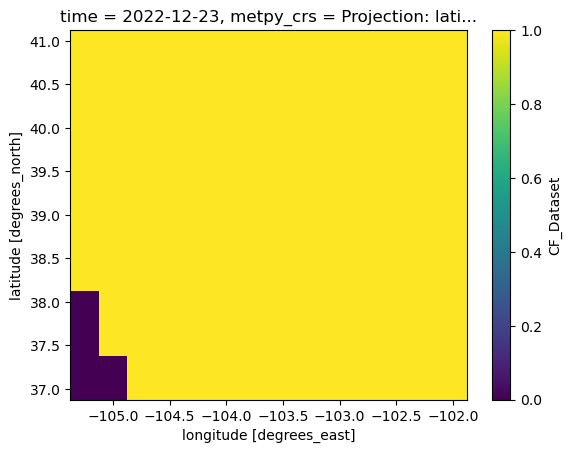

In [11]:
CF_case2plot['CF_Dataset'].plot()

Domain minimized: (38.25, 39.75, -104.0, -102.25)


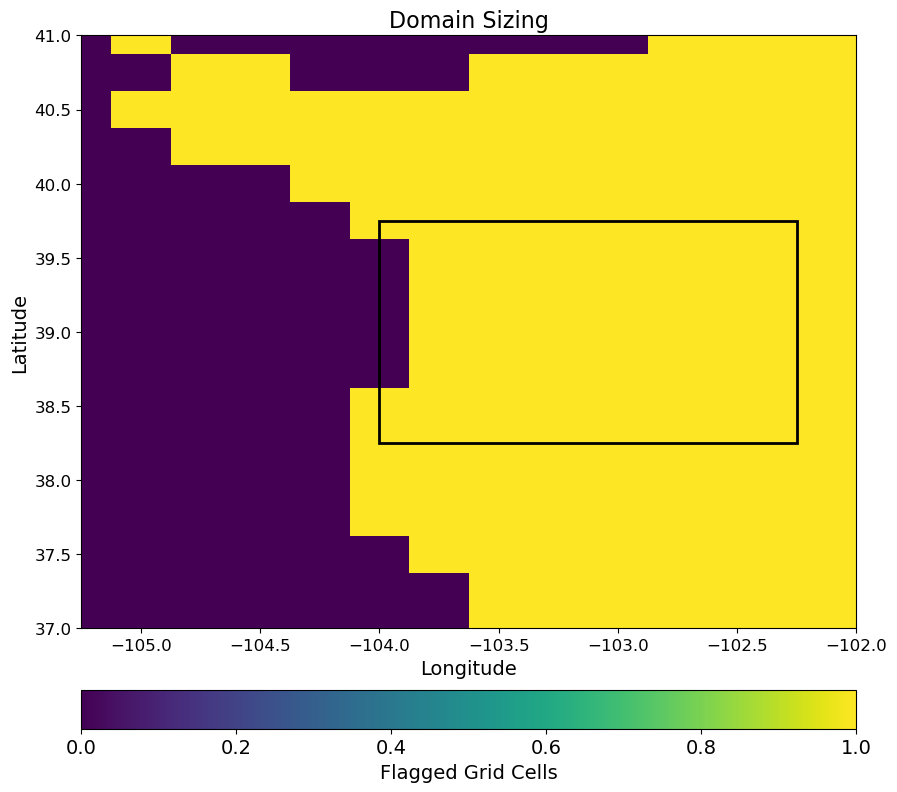

In [12]:
##Testing out continous shapes in Eastern CO that contain >=1 grid cell from all cold front days##

#Define the entire domain
testing_domain = [41, -105.25, 37.0, -102.0]

#Function to test the subregion for all cases#
def test_subregion(ds, lat_min, lat_max, lon_min, lon_max):
    '''This function will see whether a specific subregion contains >=1 flagged cell for alll 735 cases'''
    
    #Select the subregion to test#
    subregion = ds.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
    
    #Loop thru all cases#
    for i in range(len(subregion['time'])):
        
        #Check to see if there are any cases that don't have any flagged cells#
        if np.sum(subregion['CF_Dataset'][i].values) == 0:
            
            return False
        
    return True


#Function to find the smallest subregion for rectangles, thanks chatgpt#
def find_smallest_subregion(ds, domain):
    '''Find the smallest subregion by iterating'''
    
    #Extract domain values and define a step reduction per iteration
    lat_min, lon_min, lat_max, lon_max = domain
    step = 0.25 
    
    #Start with large domain and reduce until condition is not met#
    while True:
        
        if not test_subregion(ds, lat_min, lat_max, lon_min, lon_max):
            
            break  #Stop if the condition is not met
        
        #Reduce the domain size and test again#
        lat_min += step
        lat_max -= step
        lon_min += step
        lon_max -= step
    
    #Return the last valid subregion that met the condition#
    return lat_min-step, lat_max+step, lon_min-step, lon_max+step

sub_test = test_subregion(ds_CF, testing_domain[2], testing_domain[0], testing_domain[1], testing_domain[3])
#print(sub_test)

sub_test_optimize = find_smallest_subregion(ds_CF, (38.0, -104.25, 40.0, -102.0))  #37.0, -105.25, 41.0, -102.0
print(f"Domain minimized: {sub_test_optimize}")
smallest_subregion = list(sub_test_optimize).copy()


#Plotting##
fig, ax = plt.subplots(1, figsize=(10,10))
domain_cf = plt.pcolormesh(ds_CF.longitude, ds_CF.latitude, ds_CF['CF_Dataset'][100], cmap='viridis', alpha=1)
cbar = plt.colorbar(domain_cf, orientation='horizontal', pad=0.08)

ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.set_title('Domain Sizing', fontsize=16)
ax.set_xlim([-105.25, -102])  #can turn off
ax.set_ylim([37,41])          #can turn off
ax.tick_params(labelsize=12)
cbar.set_label(label='Flagged Grid Cells', size=14)
cbar.ax.tick_params(labelsize=14)

#Add a rectangle around the subregion found#
rect_domain = patches.Rectangle(
    
    (smallest_subregion[2], smallest_subregion[0]), #(lon_min, lat_min)
    smallest_subregion[3] - smallest_subregion[2],  #width (lon_max - lon_min)
    smallest_subregion[1] - smallest_subregion[0],  #height (lat_max - lat_min)
    linewidth=2,
    edgecolor='black',
    facecolor='none'
)

ax.add_patch(rect_domain)

plt.show()

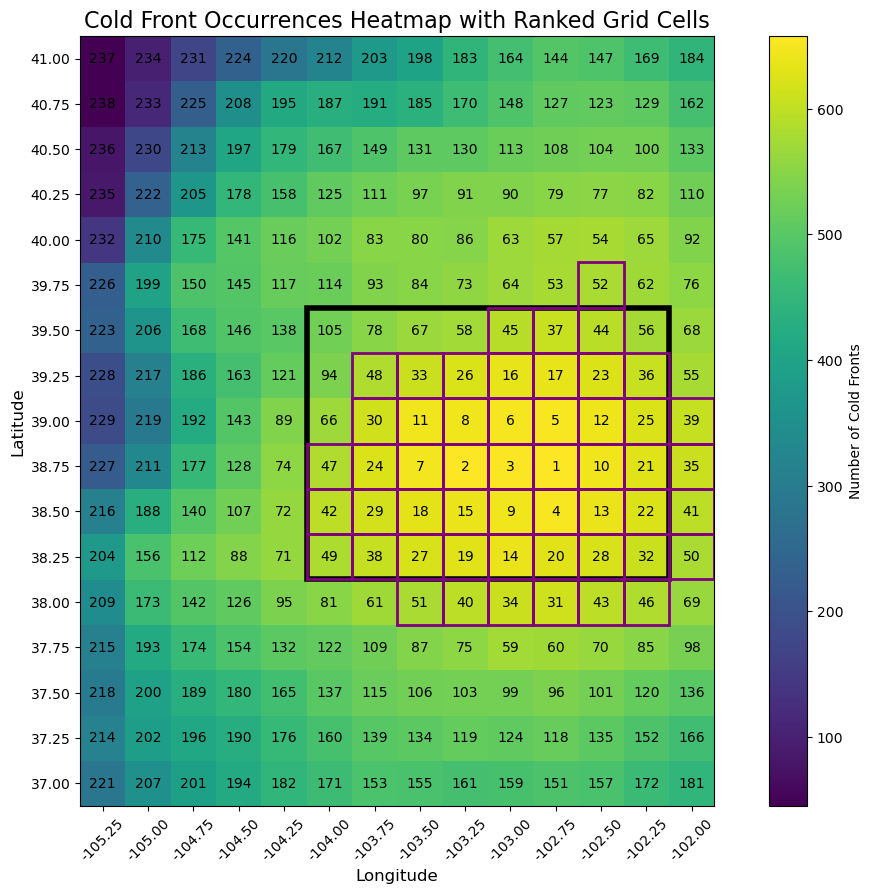

In [13]:
##The grid cell ranking method##

#Remake the spatial heatmap#
cold_front_counts = ds_CF['CF_Dataset'].sum(dim='time')

#Sort the counts to obtain ranks for each grid cell#
flattened_counts = cold_front_counts.values.flatten()
sorted_indices = np.argsort(-flattened_counts)  #Negative for descending sort

ranks = np.empty_like(sorted_indices)
ranks[sorted_indices] = np.arange(len(sorted_indices)) + 1  #Rank starts from 1

#Plot the heatmap plot underneath#
fig, ax = plt.subplots(figsize=(14, 10))
heatmap = ax.imshow(cold_front_counts, cmap='viridis', origin='lower') 

plt.colorbar(heatmap, label='Number of Cold Fronts')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('Cold Front Occurrences Heatmap with Ranked Grid Cells', fontsize=16)

#Fix the lons and lats#
lat_vals = np.flip(ds_CF['latitude'].values)  
lon_vals = ds_CF['longitude'].values  

ax.set_xticks(np.arange(len(lon_vals)))
ax.set_yticks(np.arange(len(lat_vals)))
ax.set_xticklabels([f'{lon:.2f}' for lon in lon_vals])
ax.set_yticklabels([f'{lat:.2f}' for lat in lat_vals])
plt.xticks(rotation=45)

#Convert ranks to 2D grid and print them out on cells#
ranks_2d = ranks.reshape(cold_front_counts.shape)
lon = cold_front_counts['longitude'].values
lat = cold_front_counts['latitude'].values

#Overlay original smallest rectangle#
rect_domain2 = patches.Rectangle(
    
    (5-0.5, 5-0.5), #(lon_min, lat_min)
    13 - 5,  #width (lon_max - lon_min)
    11 - 5,  #height (lat_max - lat_min)
    linewidth=4,
    edgecolor='black',
    facecolor='none'
)

ax.add_patch(rect_domain2)

#Print out the ranks in each grid cell#
for i, row in enumerate(ranks_2d):   
        for j, rank in enumerate(row):
        
            if rank <= 238: 
                ax.text(j, i, str(rank), ha='center', va='center', color='black', fontsize=10)
        
#Now make a mask for the highest frequency 52 cells#
top_cells = np.dstack(np.unravel_index(np.argsort(ranks_2d.ravel()), ranks_2d.shape))[0][:52]

#Initialize the binary mask array#
binary_mask_tc = np.zeros_like(ranks_2d, dtype=bool)

#Set the top 52 cells in the mask to True#
for cell in top_cells:
    binary_mask_tc[cell[0], cell[1]] = True

# Now binary_mask is a binary mask of the top 52 ranked grid cells
# You can use this binary mask as needed, for example:
# FLF_flagonly = FLF_ECO * binary_mask

#Add outlines for the top 52 cells#
for cell in top_cells:
    rect = patches.Rectangle((cell[1]-0.5, cell[0]-0.5), 1, 1, linewidth=2, edgecolor='purple', facecolor='none')
    ax.add_patch(rect)

plt.show()

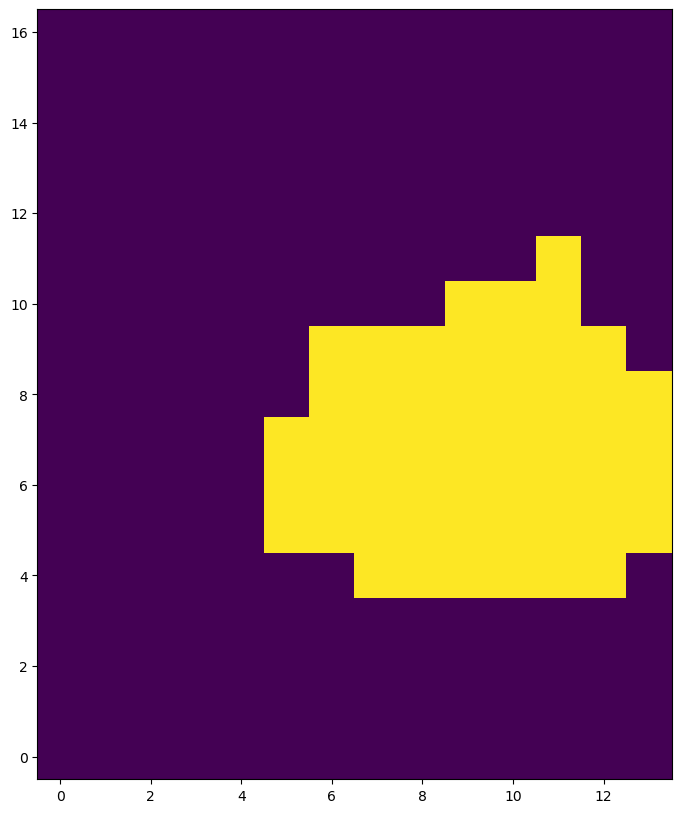

In [14]:
fig, ax = plt.subplots(figsize=(14, 10))
heatmap = ax.imshow(binary_mask_tc, cmap='viridis', origin='lower') 

#binary_mask_tc

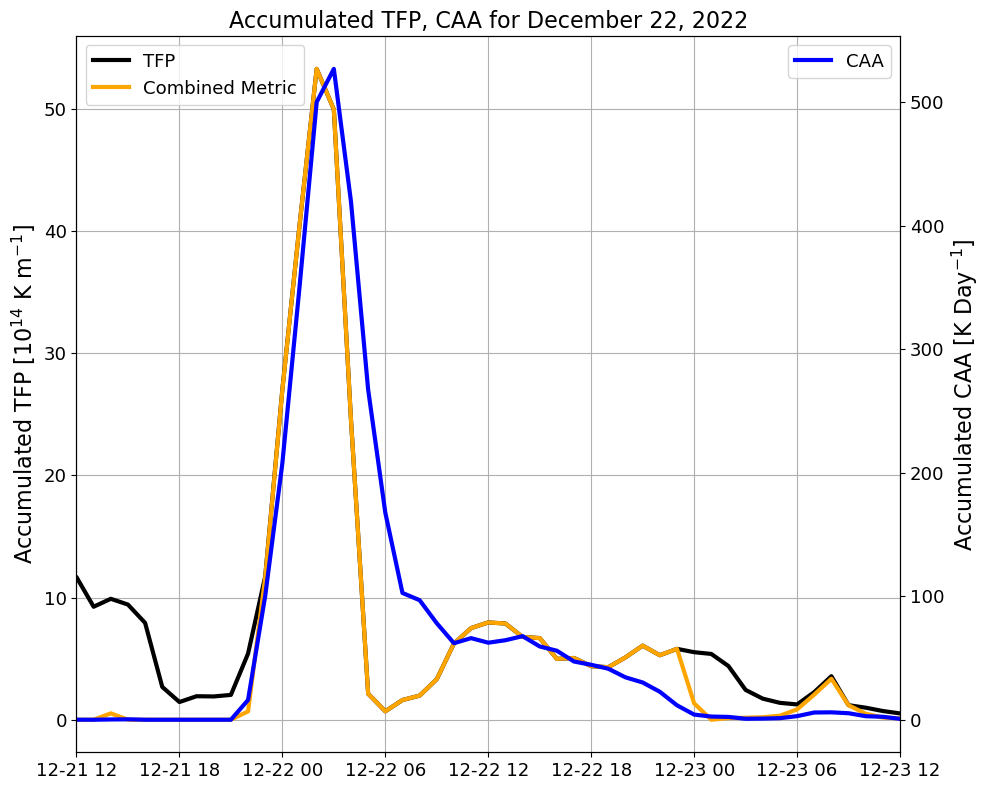

In [26]:
##We want to extract the FLF values for the Eastern CO domain##

#First remove all the frontolysis values#
FLF_data_FG = FLF_data.where(FLF_data <= 0, other=np.nan)

#Obtain the CAA for Theta#
thetaE_CAA = thetaE_adv_s_CAA.copy()

#Define extents and subset#
ECO_area = [41, -105.25, 37, -102]  #Eastern CO  105.25
minimized_area = list(sub_test_optimize).copy()

FLF_ECO = FLF_data_FG.sel(latitude=slice(ECO_area[0],ECO_area[2]),longitude=slice(ECO_area[1],ECO_area[3]))
Max_FLF_ECO = FLF_data_FG.sel(latitude=slice(minimized_area[1],minimized_area[0]),longitude=slice(minimized_area[2],minimized_area[3]))
thetaE_CAA_ECO = thetaE_CAA.sel(latitude=slice(ECO_area[0],ECO_area[2]),longitude=slice(ECO_area[1],ECO_area[3]))

#Define a start date#
start_date = str(FLF_ECO['time'][0].values)

#Create a mask from the flagged grid cells to consider only#
# mask_gc = ds_CF['CF_Dataset'][280] == 1  #need to change
# FLF_flagonly = FLF_ECO * mask_gc

#Create a second permanent mask using the 52 highest freq. gridcells and subset data#
binary_mask_tcf = np.flipud(binary_mask_tc)

FLF_top52flag = FLF_ECO * binary_mask_tcf
thetaE_CAA_top52flag = thetaE_CAA_ECO * binary_mask_tcf

#Accumulate the FLF, ThetaEadv for the different regions#
FLF_accumulated_top52 = abs(FLF_top52flag).sum(dim=['latitude', 'longitude'])
FLF_accumulated_ECO = abs(FLF_ECO).sum(dim=['latitude', 'longitude'])
#FLF_accumulated_MAX = abs(Max_FLF_ECO).sum(dim=['latitude', 'longitude'])

thetaE_CAA_accumulated_ECO = abs(thetaE_CAA_ECO).sum(dim=['latitude', 'longitude'])
thetaE_CAA_accumulated_top52 = abs(thetaE_CAA_top52flag).sum(dim=['latitude', 'longitude'])

#Plotting with pandas dates#
dates = pd.date_range(start=start_date, periods=FLF_accumulated_top52.sizes['time'], freq='H')
dates = pd.to_datetime(dates)

FLF_timeseries = pd.Series(data=FLF_accumulated_top52.values, index=dates)
FLF_timeseries2 = pd.Series(data=thetaE_CAA_accumulated_top52.values, index=dates)
FLF_timeseries3 = pd.Series(data=FLF_accumulated_ECO.values, index=dates)
FLF_timeseries4 = pd.Series(data=thetaE_CAA_accumulated_ECO.values, index=dates)

##Try an overlap with FLF and CAA now##

#Create a new DataArray that only contains FLF values where CAA is non-zero#
FLF_and_CAA = xr.where(thetaE_CAA_top52flag.values < 0, FLF_top52flag, 0)  
FLF_CAA_accumulated = abs(FLF_and_CAA).sum(dim=['latitude', 'longitude'])
FLF_CAA_timeseries = pd.Series(data=FLF_CAA_accumulated.values, index=dates)

FLF_and_CAA_ECO = xr.where(thetaE_CAA_ECO.values < 0, FLF_ECO, 0)  
FLF_CAA_accumulated_ECO = abs(FLF_and_CAA_ECO).sum(dim=['latitude', 'longitude'])
FLF_CAA_timeseries_ECO = pd.Series(data=FLF_CAA_accumulated_ECO.values, index=dates)

FLF_timeseries_conv = FLF_CAA_timeseries * FLF_timeseries2   #combine orange and blue lines

 #Plotting#

#Make plot 1 for T52#
fig, ax = plt.subplots(figsize=(10,8))
ax2 = ax.twinx() 
ax.plot(FLF_timeseries.index, FLF_timeseries.values, linewidth=3, color='black', label='TFP')
ax2.plot(FLF_timeseries2.index, FLF_timeseries2.values, linewidth=3, color='blue', label='CAA')
ax.plot(FLF_CAA_timeseries.index, FLF_CAA_timeseries.values, linewidth=3, color='orange', label='Combined Metric')
#ax2.plot(FLF_timeseries_conv.index, FLF_timeseries_conv.values, linewidth=3, color='purple', linestyle='--', label='Weighted')

ax.legend(loc='upper left', fontsize=13)
ax2.legend(loc='upper right', fontsize=13)
plt.xticks(rotation=90)
#ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel(r'Accumulated TFP [$10^{{14}}$ K m$^{{-1}}$]', fontsize=16)
ax2.set_ylabel(r'Accumulated CAA [K Day$^{{-1}}$]', fontsize=16)  #Label for the second y-axis
ax.set_title(f'Accumulated TFP, CAA for December 22, 2022', fontsize=16)  #change
ax.set_xlim([dates[12],dates[60]])
ax.tick_params(labelsize=13)
ax2.tick_params(labelsize=13)
ax.grid(True)  
plt.tight_layout()  

plt.savefig(f'CAA_FLF_{dates[47]}.png', dpi=150)

# #Make plot 2 for Eastern CO#
# fig, ax = plt.subplots(figsize=(10,8))
# ax2 = ax.twinx() 
# ax.plot(FLF_timeseries3.index, FLF_timeseries3.values, linewidth=3, color='black', label='ECO FLF')
# ax2.plot(FLF_timeseries4.index, FLF_timeseries4.values, linewidth=3, color='blue', label='ECO CAA')
# ax.plot(FLF_CAA_timeseries_ECO.index, FLF_CAA_timeseries_ECO.values, linewidth=3, color='orange', label='ECO: FLF and CAA')

# ax.legend(loc='upper left')
# ax2.legend(loc='upper right')
# plt.xticks(rotation=45)
# ax.set_xlabel('Time', fontsize=14)
# ax.set_ylabel('Accumulated Scaled FLF', fontsize=14)
# ax2.set_ylabel('Accumulated Scaled CAA', fontsize=14)  #Label for the second y-axis
# ax.set_title(f'Timeseries of Accumulated FLF,CAA ECO for {dates[47]}', fontsize=16)  #change
# ax.set_xlim([dates[12],dates[60]])
# ax.grid(True)  
# plt.tight_layout()  

# plt.show()

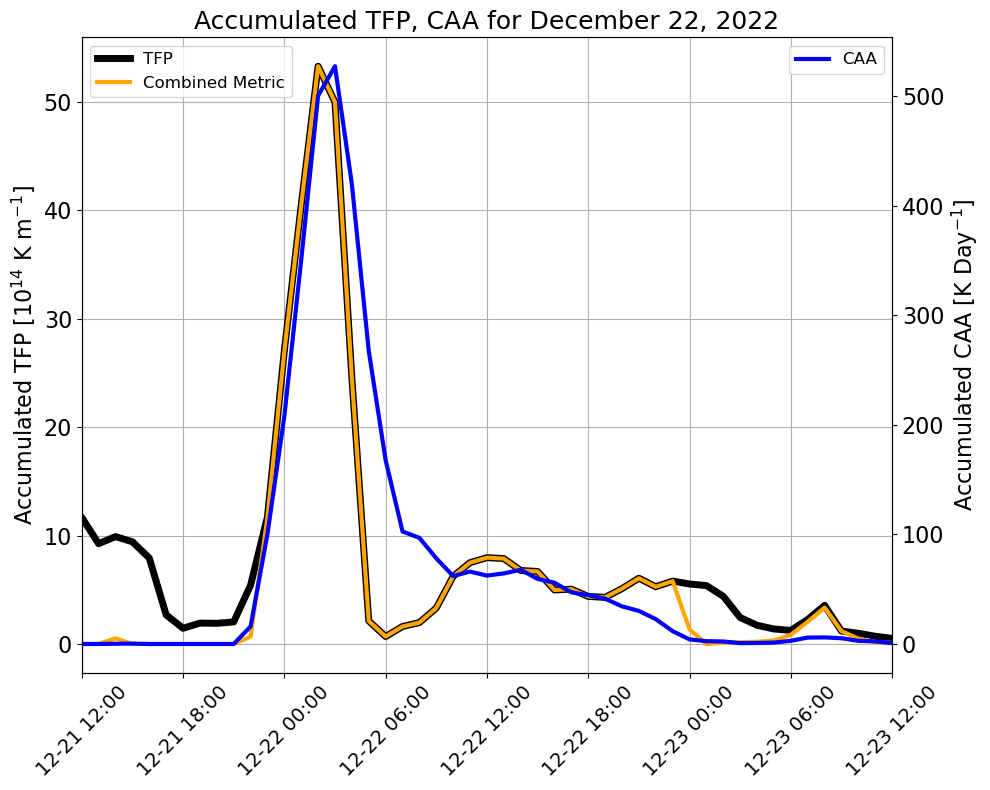

In [39]:
###Remake this figure better###
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator, FuncFormatter

#Make plot 1 for T52#
fig, ax = plt.subplots(figsize=(10,8))
ax2 = ax.twinx() 

#Plot with adjusted line widths and zorders#
ax.plot(FLF_timeseries.index, FLF_timeseries.values, linewidth=5, color='black', label='TFP', zorder=2)
ax2.plot(FLF_timeseries2.index, FLF_timeseries2.values, linewidth=3, color='blue', label='CAA', zorder=1)
ax.plot(FLF_CAA_timeseries.index, FLF_CAA_timeseries.values, linewidth=3, color='orange', label='Combined Metric', zorder=3)

# Legends
ax.legend(loc='upper left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)

# Axis formatting
#plt.xticks(rotation=45, fontsize=18)              # Rotate and resize x-axis ticks
ax.set_yticklabels(ax.get_yticks(), fontsize=16)  # Resize y-axis ticks (left)
ax2.set_yticklabels(ax2.get_yticks(), fontsize=16)  # Resize y-axis ticks (right)

# Format x-axis time display
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
ax.tick_params(axis='x', labelrotation=45, labelsize=14)

# Axis labels
ax.set_ylabel(r'Accumulated TFP [$10^{{14}}$ K m$^{{-1}}$]', fontsize=16)
ax2.set_ylabel(r'Accumulated CAA [K Day$^{{-1}}$]', fontsize=16)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

# Title and limits
ax.set_title(f'Accumulated TFP, CAA for December 22, 2022', fontsize=18)
ax.set_xlim([dates[12], dates[60]])

# Grid and layout
ax.grid(True)  
plt.tight_layout()

# Save the figure
plt.savefig(f'CAA_FLF_{dates[47]}.png', dpi=150)

In [16]:
FLF_timeseries2

2022-12-21 00:00:00    74.579821
2022-12-21 01:00:00    79.266415
2022-12-21 02:00:00    68.904322
2022-12-21 03:00:00    54.672789
2022-12-21 04:00:00    39.441593
                         ...    
2022-12-23 19:00:00     0.518456
2022-12-23 20:00:00     1.471425
2022-12-23 21:00:00     2.531886
2022-12-23 22:00:00     9.018727
2022-12-23 23:00:00     5.960261
Freq: H, Length: 72, dtype: float64

In [17]:
##Locate the maximum value and time##

#Find the index of the maximum value#
max_index = FLF_timeseries_conv[12:60].idxmax()  

#Retrieve the maximum value#
max_value = FLF_timeseries_conv[max_index]

print(f"The maximum value is {max_value} and it occurs on {max_index}")

The maximum value is 26650.560466321385 and it occurs on 2022-12-22 02:00:00


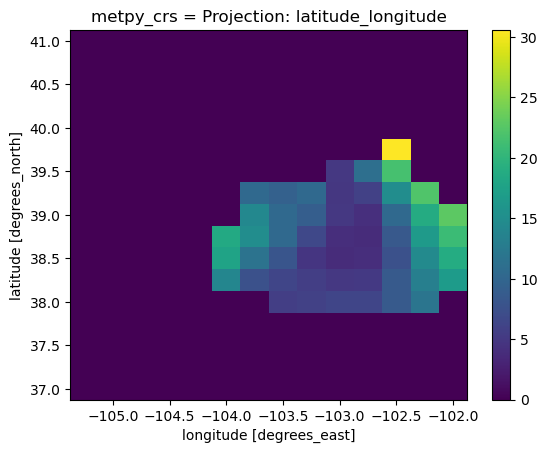

In [18]:
hiiii = abs(FLF_top52flag).sum(dim=['time'])

hiiii.plot()